# Данные

## Подготовка данных (задание 1)

Скачиваем данные из https://ourworldindata.org/coronavirus-source-data  
Затем выбираем данные для России старше 3 марта 2020 года

In [ ]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2022-03-07 18:56:42--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.137, 104.21.233.138, 2606:4700:3038::6815:e989, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv.1’

owid-covid-data.csv     [   <=>              ]  45.28M   103MB/s    in 0.4s    

2022-03-07 18:56:43 (103 MB/s) - ‘owid-covid-data.csv.1’ saved [47479300]



In [ ]:
import numpy as np
import pandas as pd
import datetime

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
start_date = datetime.datetime(2020, 3, 3)


data = pd.read_csv('owid-covid-data.csv')
data = data[(data.location == 'Russia') & (data.date >= str(start_date))]
print('Количество данных', data.shape)
print(f'Минимальное кол-во заболевших: {data.total_cases.min()}')
data.head()

Количество данных (733, 67)
Минимальное кол-во заболевших: 3.0


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
123956,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123957,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123958,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123959,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123960,RUS,Europe,Russia,2020-03-08,17.0,4.0,2.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


## Данные для моделирования (задание 1)

В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases). 
Зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта. 
Для упрощения обработки заменим в столбце new_cases все нули на единицы.

In [ ]:
targets = ['total_cases', 'new_cases']
data[targets[1]] = data[targets[1]].replace(0, 1)

data = data.sort_values('date').reset_index()
train_indices = data[(data.date >= '2020-03-03') & (data.date < str(start_date + datetime.timedelta(days=50)))].index

In [ ]:
assert (data.date.value_counts() > 1).sum() == 0, 'Есть строки с одинаковой датой'
assert ((pd.to_datetime(data.date).dt.date - pd.to_datetime(data.date).shift(1).dt.date).dt.days > 1).sum() == 0, 'Есть пропуски дат'

# Моделирование

## Визуализация целевых переменных (задание 2)

Построим графики целевых переменных:

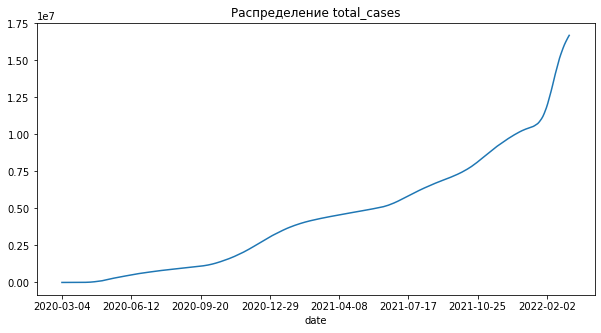

In [ ]:
plot_data = data[targets + ['date']].copy()
plot_data = plot_data.set_index('date')
plot_data[targets[0]].plot(title=f'Распределение {targets[0]}', figsize=(10, 5))

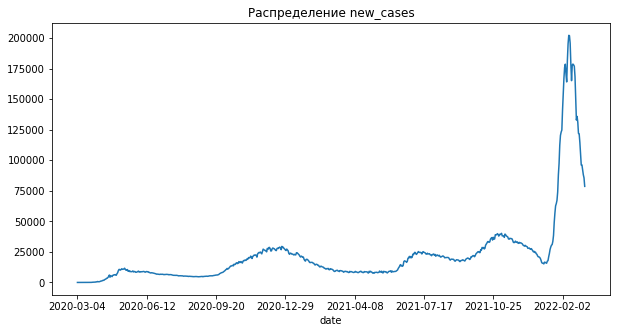

In [ ]:
plot_data[targets[1]].plot(title=f'Распределение {targets[1]}', figsize=(10, 5))

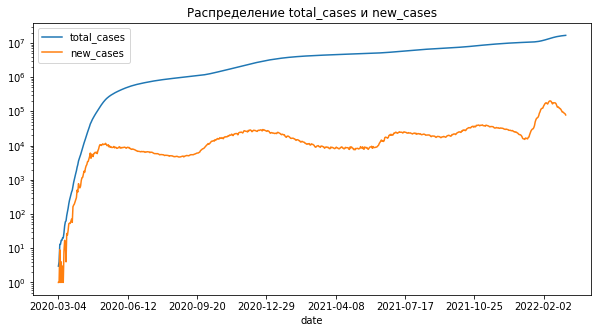

In [ ]:
plot_data[targets].plot(title=f'Распределение {targets[0]} и {targets[1]}', figsize=(10, 5), logy=True)

Да, действительно, распределение количества заболевших имеет сходство с экпонентой или степенной функцией. Возрастает быстро и выходит на 


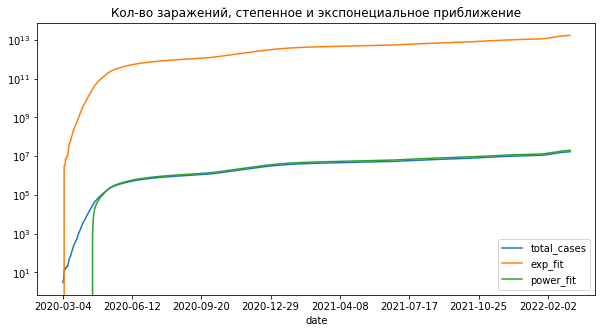

In [ ]:
a1, b1 = np.polyfit(np.log(data[targets[0]]), data[targets[0]], 1)
a3, b3 = np.polyfit(np.power(data[targets[0]], 1 - 0.01), data[targets[0]], 1)

plot_data['exp_fit'] = (a1 * data[targets[0]] + b1).tolist()
plot_data['power_fit'] = (a3 * data[targets[0]] + b3).tolist()
plot_data[[targets[0], 'exp_fit', 'power_fit']].plot(title=f'Кол-во заражений, степенное и экспонециальное приближение', figsize=(10, 5), logy=True)

## Линейная регрессия (задание 2a)

Используя линейную регрессию, обучаем модель с экспоненциальным ростом числа заболевших: y = exp(f(x)) -> ln(y) = f(x)

In [ ]:
train = data.loc[train_indices].copy()
test = data[~data.index.isin(train.index)].copy()
assert train.shape[0] == 50, 'Трейн не 50 дней'
assert train.shape[0] + test.shape[0] == data.shape[0], 'неправильный трейн или тест'

In [ ]:
# отсориторовано по дате, пропусков дат нет
# index 0 - 1ый день
x_train = (train.index.values + 1).reshape(-1, 1)
y_train = np.log(train[targets[0]]).values

lr = LinearRegression().fit(x_train, y_train)

data[f'prediction_{targets[0]}'] = np.exp(
    lr.predict(
        (data.index.values + 1).reshape(-1, 1)
        )
    ).tolist()
print(f'Наклон: {lr.coef_}, смещение {lr.intercept_}')

Наклон: [0.1947175], смещение 1.9109596753423403


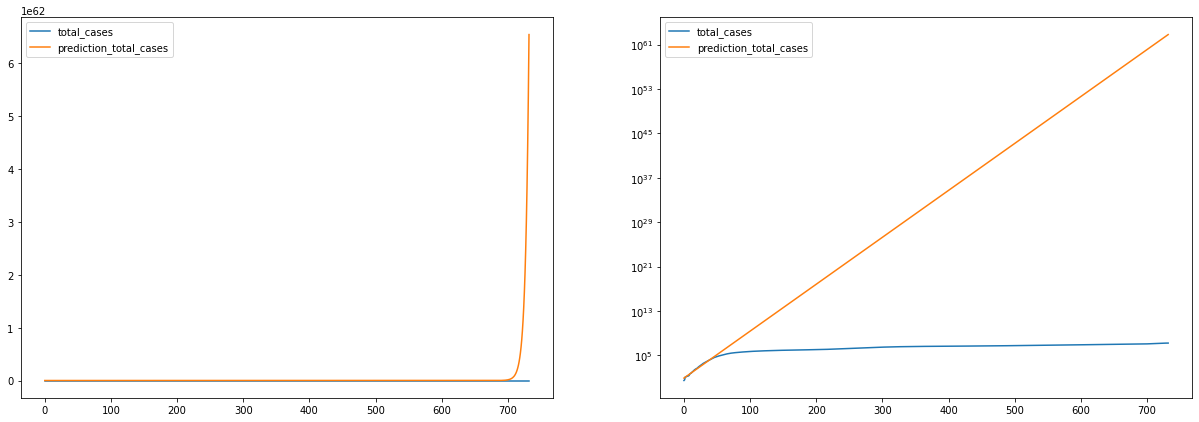

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

ax = data[[targets[0], f'prediction_{targets[0]}']].plot(title='', ax=axes[0])
data[[targets[0], f'prediction_{targets[0]}']].plot(title='', logy=True, ax=axes[1])

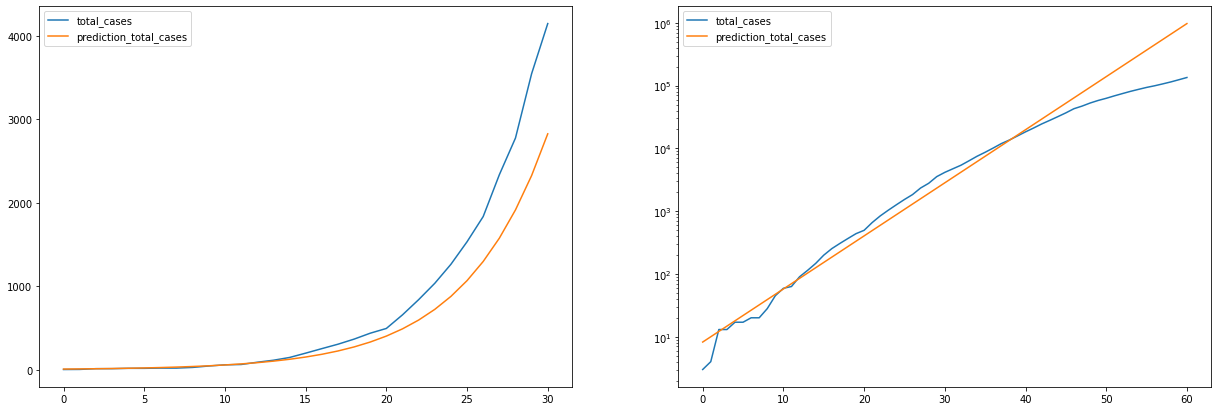

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

ax = data.loc[:30, [targets[0], f'prediction_{targets[0]}']].plot(title='', ax=axes[0])
data.loc[:60, [targets[0], f'prediction_{targets[0]}']].plot(title='', logy=True, ax=axes[1])

In [ ]:
sigma = (y_train - lr.predict((train.index.values + 1).reshape(-1, 1))).var()
print('Дисперсия', sigma)

Дисперсия 0.12051006246973671


In [ ]:
X = np.stack((y_train.T, np.ones(len(y_train))), axis=1)

In [ ]:
cov = np.linalg.inv(np.eye(2) / (sigma * 0.01) + np.matmul(X.T, X) / sigma)
mu = np.matmul(np.matmul(cov, X.T), y_train.T) / sigma

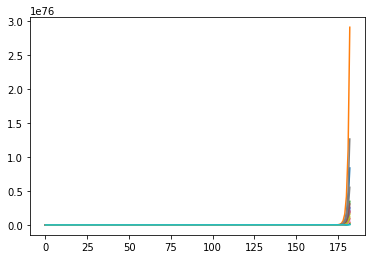

In [ ]:
xs = np.arange(183)
first_may = []
first_june = []
first_september = []

for i in range(20):
    w1, w0 = np.random.multivariate_normal(mu, cov)
    first_may.append(np.exp(w1 * 59 + w0))
    first_june.append(np.exp(w1 * 90 + w0))
    first_september.append(np.exp(w1 * 182 + w0))
    plt.plot(xs, np.exp(w1 * xs + w0)) 
plt.show()

In [ ]:
print("1 мая предсказывается {} +/- {} случаев короновируса".format(int(np.mean(first_may)), int(np.std(first_may))))
print("1 июня предсказывается {} +/- {} случаев короновируса".format(int(np.mean(first_june)), int(np.std(first_june))))
print("1 сентября предсказывается {} +/- {} случаев короновируса".format(int(np.mean(first_september)), int(np.std(first_september))))

1 мая предсказывается 2786111724451648577208320 +/- 1365578255472377471172608 случаев короновируса
1 июня предсказывается 20074832576251831759171645388118556672 +/- 15251284989219720465033820946772787200 случаев короновируса
1 сентября предсказывается 3924203751423559213338240988335770890229078524175195596952505069204557266944 +/- 6534634226794923859926720252473076281678708287772866358242664082802856689664 случаев короновируса
